<a href="https://colab.research.google.com/github/m3sibti/genomic_datascience/blob/master/PixelMotifGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Data Preparation

#### Download links for files

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
web_main_link = "http://jaspar.genereg.net"

Step by step procedure

In [ ]:
'''
# make simple request
r = requests.get(f"{web_main_link}/search?", params= dict(
                 page=1,
                 q="Homo sapiens",
                 tax_group="vertebrates",
                 page_size=250,
                 collection="CORE"))

soup = BeautifulSoup(r.text, "html.parser")

tags = soup.find("table", id = "search_table")

tags2 = tags.find_all("tr")
len(tags2)

rowsWithoutHeader = tags2[1:]
len(rowsWithoutHeader)

linksToData = []
for row in rowsWithoutHeader:
  dataItemLink = row.find("td", id='profile_summary').find('a').get('href')
  linksToData.append(web_main_link + dataItemLink)

linksToData
'''

A Function to extract all the links from the given website

In [ ]:
def getAllDataItemLinks(web_main_link, num_pages,
                        filter="Homo sapiens",
                        group="vertebrates"):
  linksToDownload = []
  for i in range(1, num_pages+1):
    # make requests
    r = requests.get(f"{web_main_link}/search?", params= dict(
                 page=i,
                 q=filter,
                 tax_group=group,
                 page_size=250,
                 collection="CORE"))
    
    # convert the response to html file
    soup = BeautifulSoup(r.text, "html.parser")
    search_table = soup.find("table", id = "search_table")
    useful_rows = search_table.find_all("tr")
    rowsWithoutHeader = useful_rows[1:]
    for row in rowsWithoutHeader:
      dataItemLink = row.find("td", id='profile_summary').find('a').get('href')
      linksToDownload.append(web_main_link + dataItemLink)

  # remove repitions because they were 870 instead of 810
  listWithNoRepition = list(dict.fromkeys(linksToDownload))
  '''
   after this process they remain 810,
   which are the number of homo sepian items at the website
   '''
  return listWithNoRepition


In [ ]:
listOfLinks = getAllDataItemLinks("http://jaspar.genereg.net", num_pages=5)
len(listOfLinks)

810

Gather the downloadable links from data items

In [ ]:
downloadableFiles = []

for flink in listOfLinks:
  r = requests.get(flink)
  soup = BeautifulSoup(r.text, "html.parser")
  body_box = soup.find_all("div", "box-body")[4]
  itemToGo = body_box.find('a')
  if itemToGo != None:
    downloadableFiles.append(itemToGo.get('href'))


In [ ]:
print(f"we have total {len(downloadableFiles)} downloadable files")

we have total 323 downloadable files


Write your data into files

In [ ]:
with open('linksToGetMotifs.txt', 'w') as f:
    for item in downloadableFiles:
        f.write(f"{web_main_link + item}\n")

Downloadable files

In [ ]:
webLinks = [web_main_link + item for item in downloadableFiles]

In [ ]:
len(webLinks)

323

#### Visit Links

In [ ]:
# len(webLinks)

323

Downlad File

In [2]:
!wget -O motifLinks.txt -q "https://nustedupk0-my.sharepoint.com/:t:/g/personal/smalik_mscse18_rcms_nust_edu_pk/EWa8FZcPR2tEuQ-R9HCUJOMBoXmW5HC-90yFk07rFYD5Ng?e=L5JLSZ&download=1"

In [3]:
f = open("motifLinks.txt", 'r')
motifLinks = f.read().split('\n')
motifLinks = motifLinks[:-1]
print(f'we have total {len(motifLinks)} links')

we have total 323 links


##### Get Motifs from HTML

A Function to get motifs using `how_many`

In [ ]:
def getMotif(webLinks, how_many=1):

  def getProperMotifs(linkToVisit):
    r = requests.get(linkToVisit)
    soup = BeautifulSoup(r.text, 'html.parser')
    allMotifs = soup.find_all('pre')
    return allMotifs

  if how_many == 1:
    firstLink = webLinks[0]
    allMotifs = getProperMotifs(firstLink)
    myMotifs = [l.text for l in allMotifs if len(l.text) > 2]
    return myMotifs

  else:
    motifLists = []
    for mLink in webLinks[:how_many]:
      collectionName = mLink.split('/')[4]
      allMotifs = getProperMotifs(mLink)
      myMotifs = [l.text for l in allMotifs if len(l.text) > 2]
      motifLists.append({collectionName: myMotifs})
    return motifLists


use this function to make a call for them

In [ ]:
# motifLists = getMotif(motifLinks, how_many=1)

##### Download Motif Files

Create downloadable links

In [4]:
def createDownloadLinks(motifLinks):
  motifDownloableLinks = []
  for li in motifLinks:
     nl = li.split('/')
     nl.insert(3, 'download')
     nl[-1] = nl[-1] + '.sites'
     separter = '/'
     downloadableLink = separter.join(nl)
     motifDownloableLinks.append(downloadableLink)

  return motifDownloableLinks

In [5]:
downloadableLinks = createDownloadLinks(motifLinks)
print('A single link look alike: \n',downloadableLinks[0])

A single link look alike: 
 http://jaspar.genereg.net/download/sites/MA0007.2.sites


Download Files

In [6]:
# download files for motif dataset

# set the directory name
dir_name = 'data_files'
# create the directory if not already
os.makedirs(dir_name, exist_ok=True)

# currently downloading only 10 files - change it according to your requirement,
print('Downloading 100 Motif Files....')
for ilink in tqdm(downloadableLinks[:100]):
  fileName = ilink.split('.sites')[0].split('/')[-1]
  urllib.request.urlretrieve(ilink, f'{dir_name}/{fileName}.txt')

In [ ]:
# remove data files when not needed
# !rm -r data_files

#### Extract data from files

In [7]:
file_paths = sorted([ dir_name+"/"+f for f in os.listdir(dir_name) ])
file_paths

['data_files/MA0007.2.txt',
 'data_files/MA0018.1.txt',
 'data_files/MA0018.2.txt',
 'data_files/MA0018.3.txt',
 'data_files/MA0018.4.txt',
 'data_files/MA0024.1.txt',
 'data_files/MA0024.2.txt',
 'data_files/MA0028.1.txt',
 'data_files/MA0030.1.txt',
 'data_files/MA0031.1.txt',
 'data_files/MA0035.4.txt',
 'data_files/MA0036.1.txt',
 'data_files/MA0036.2.txt',
 'data_files/MA0036.3.txt',
 'data_files/MA0037.1.txt',
 'data_files/MA0037.2.txt',
 'data_files/MA0043.1.txt',
 'data_files/MA0043.3.txt',
 'data_files/MA0047.3.txt',
 'data_files/MA0062.1.txt',
 'data_files/MA0062.3.txt',
 'data_files/MA0076.1.txt',
 'data_files/MA0076.2.txt',
 'data_files/MA0098.1.txt',
 'data_files/MA0099.2.txt',
 'data_files/MA0102.3.txt',
 'data_files/MA0102.4.txt',
 'data_files/MA0112.1.txt',
 'data_files/MA0112.2.txt',
 'data_files/MA0131.1.txt',
 'data_files/MA0139.1.txt',
 'data_files/MA0140.2.txt',
 'data_files/MA0148.1.txt',
 'data_files/MA0148.3.txt',
 'data_files/MA0148.4.txt',
 'data_files/MA0149.

Working on a single file

In [8]:
#first_path = file_paths[0]
pos_files, neg_files = list(), list()
for fpath in file_paths:
  file_data = open(fpath, 'r')
  pos_ix = list()
  neg_ix = list()
  t_data = file_data.read().split('>')[1:]
  for i, xi in enumerate(t_data):
    if '(+)' in xi:
      pos_ix.append(i)
    elif '(-)' in xi:
      neg_ix.append(i)
  pos_files.append([t_data[i] for i in pos_ix])
  neg_files.append([t_data[i] for i in neg_ix])

  # x_pos = [t_data[i] for i in pos_ix]
  # x_neg = [t_data[i] for i in neg_ix]
x_pos = sum(pos_files, [])
x_neg = sum(neg_files, [])
print(f'{len(x_pos)} Postives\n{len(x_neg)} Negatives')

1785019 Postives
1784738 Negatives


In [9]:
def get_useful_data(mf):
  m_data = [ k 
            for f in mf
            for k in f.split('\n')
            if not k.startswith('h')]
  combine_data = ''.join(m_data)
  print(f'we have total {len(combine_data)} alphabets.')
  return combine_data

pos_data = get_useful_data(x_pos)
neg_data = get_useful_data(x_neg)

we have total 39655632 alphabets.
we have total 39466849 alphabets.


Define Image Data for conversion

In [10]:
img_shape = (28, 28)
img_size = img_shape[0]*img_shape[1]
total_pos_imgs = len(pos_data) // img_size
total_neg_imgs = len(neg_data) // img_size

print(f"Our image size {img_shape[0]} * {img_shape[1]} = ", img_size)
print("total postive images from these file =",total_pos_imgs)
print("total negative images from these file =",total_neg_imgs)

Our image size 28 * 28 =  784
total postive images from these file = 50581
total negative images from these file = 50340


In [11]:
pos_imgs_data = []
neg_imgs_data = []
for i in range(total_pos_imgs):
  start = i * img_size
  end = (i+1) * img_size
  pos_imgs_data.append(pos_data[start:end])

for i in range(total_neg_imgs):
  start = i * img_size
  end = (i+1) * img_size
  neg_imgs_data.append(neg_data[start:end])

print('\nA postive image look like:\n',pos_imgs_data[0])
print('\nA negative image look like:\n',neg_imgs_data[0])


A postive image look like:
 aacaatctcactcaaagatggatatgatgattttatgagacttttcagagAGGAACAGAGTGTTCtgtttgcatagagaatagtcacattgtgttaggagcatgctgttactatttccagctcattcacctttaactcaggcttttcatggggctgggctgcctcAGGAACAGAGTGTTCagccaaagcacagcttcacctctctcctcctggccttatctgatctggccatagaagtggtcctacagctgtgtgcaggaaggctgtatattttaacaagAGGAACAGAGTGTGCtgttgagaatagaggacaatgaattaagaatcgggcctagaaaacactgggatttctataaattctctttgatttagaaccatacttgtattctctacctAGGAACAGAGTGTTCctattgattgtttaaaaagaggaaacttcttgaacacagctgagtactgagatgcatttcccccatttaggaattacaactcaggaagaaacattctaaaAGGAACAGACTGTTCctttgagtgtcagaagccacaataaatatttttacagtagaatctaaatagcggggccagtgccttccgttttctggagaatgatgagtcgtagatgaaaAAGAACAGAGTGTGCtggacaatacccaagagttattcagaacaagcaaatgtgttcctgggcagttaataaatttcaaaacttggaacaatgttagatttacaaaaacgtcagaAAGAACAGAGTGTTCctgtttattctttatatagcctttttttt

A negative image look like:
 aaagttgtgttaaaaaattaataatcttgtaatgcactatttggaaacgtAGGAACAGAGTGTGCagtcaactcagccagcagtgtttgaattagcctcagagacagaggcttgtatagctgtcctttactgcgtggctggccccgtgccatgggg

Functions to encode and decode characters into numerical values

In [12]:
def giveNumberAgainstChar(char):
  if char == 'a':
    return 0
  elif char == 'c':
    return 85
  elif char == 't':
    return 170
  elif char == 'g':
    return 255

def giveCharAgainstNumber(n):
  if n is 0:
    return 'a'
  elif n is 85:
    return 'c'
  elif n is 170:
    return 't'
  elif n is 255:
    return 'g'

In [13]:
# checking the range
# (0 - 127.5)/127.5, (85 - 127.5)/127.5,(170 - 127.5)/127.5,(255 - 127.5)/127.5

#### Create Image Data and Visualize

Create a training batch

In [14]:
# full training images
# positive
x_pos_train_pix = np.empty(shape=(total_pos_imgs, 28, 28, 1))
x_pos_train_chr = np.empty(shape=(total_pos_imgs, 28, 28), dtype='str')
# negative
x_neg_train_pix = np.empty(shape=(total_neg_imgs, 28, 28, 1))
x_neg_train_chr = np.empty(shape=(total_neg_imgs, 28, 28), dtype='str')

print('Creating positive images..')
for i, img_data in tqdm(enumerate(pos_imgs_data)):
  # convert strings to lower case
  img_data = img_data.lower()
  # convert characters into numbers
  x_pos_train_pix[i] = np.asarray([giveNumberAgainstChar(i) for i in img_data]).reshape(28, 28, 1)
  x_pos_train_chr[i] = np.asarray([list(img_data)]).reshape(28, 28)

print('Creating negative images..')
for i, img_data in tqdm(enumerate(neg_imgs_data)):
  # convert strings to lower case
  img_data = img_data.lower()
  # convert characters into numbers
  x_neg_train_pix[i] = np.asarray([giveNumberAgainstChar(i) for i in img_data]).reshape(28, 28, 1)
  x_neg_train_chr[i] = np.asarray([list(img_data)]).reshape(28, 28)

# print shapes
print('\nShapes of positive array',x_pos_train_pix.shape, x_pos_train_chr.shape)
print('Shapes of negative array', x_neg_train_pix.shape, x_neg_train_chr.shape)

Creating positive images..



Creating negative images..




Shapes of positive array (50581, 28, 28, 1) (50581, 28, 28)
Shapes of negative array (50340, 28, 28, 1) (50340, 28, 28)


Save pos/neg images to use them later

In [25]:
# np.savez_compressed('pos_motifs.npz',x_pos_train_pix, x_pos_train_chr)
# np.savez_compressed('neg_motifs.npz',x_neg_train_pix, x_neg_train_chr)

#### Work on Prepared Training Data

Functions to encode and decode characters into numerical values

In [2]:
def giveNumberAgainstChar(char):
  if char == 'a':
    return 0
  elif char == 'c':
    return 85
  elif char == 't':
    return 170
  elif char == 'g':
    return 255

def giveCharAgainstNumber(n):
  if n is 0:
    return 'a'
  elif n is 85:
    return 'c'
  elif n is 170:
    return 't'
  elif n is 255:
    return 'g'

Display top images from training batch 

In [3]:
def show_images(img_list):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(str(i+1))
    plt.xlabel(imgs_data[i][:28])
    plt.imshow(img_list[i,...,0], cmap='binary')

def show_coupled(n_rows=2, n_cols=2, data=None, title=None):
  
  def convert_text(xi):
    m_ch_arr = list()
    for im in xi:
      marr = ''.join(im)
      m_ch_arr.append(marr)
    kik = '\n'.join(m_ch_arr)
    return kik

  x, y = data
  
  total_plots = n_rows*n_cols
  fig = plt.figure(figsize=(10, 8))
  fig.suptitle(title, fontsize=16)
  outer = gridspec.GridSpec(n_rows, n_cols, wspace=0.2, hspace=0.2)
  
  for i in range(total_plots):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    for j in range(2):
      ax = plt.Subplot(fig, inner[j])
      ax.axis('off')
      if j == 0:
        t = ax.imshow(x[i, ..., 0], cmap='gray')
        ax.set_title('Image Motif', y=1.2)
      else:
        ax.set_title('Texual Motif', y=1.2)
        ax.text(14, 14, convert_text(y[i]),
                size='xx-small',
                ha='center', va='center',
                backgroundcolor='white')
        ax.imshow(np.zeros((28,28)), cmap='gray_r')
      fig.add_subplot(ax)

**Load Stored Array**

Download data files

In [4]:
!wget -O pos_motifs.npz -q "https://nustedupk0-my.sharepoint.com/:u:/g/personal/smalik_mscse18_rcms_nust_edu_pk/EaP_gYusCEFOlbQBm3HH5xoB9384Jie2WF8fzhja_b06Cg?e=xIU6Q5&download=1"
!wget -O neg_motifs.npz -q "https://nustedupk0-my.sharepoint.com/:u:/g/personal/smalik_mscse18_rcms_nust_edu_pk/EeGtIXbaFzBGgXFKl7oAuf0BDN4tOuIh3WdXx9kc1FhIdw?e=vQ3q69&download=1"

Positive

In [8]:
pos_nparr = np.load('pos_motifs.npz')
pos_imgs = pos_nparr['arr_0']
pos_chars = pos_nparr['arr_1']
print(pos_imgs.shape)

(50581, 28, 28, 1)


Negatives

In [9]:
neg_nparr = np.load('neg_motifs.npz')
neg_imgs = pos_nparr['arr_0']
neg_chars = pos_nparr['arr_1']
print(neg_imgs.shape)

(50581, 28, 28, 1)


**Visualize Data**

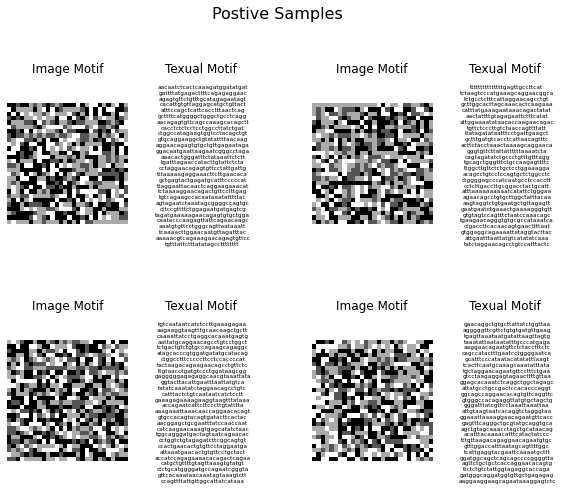

In [10]:
# show_images(x_train)
show_coupled(data=(pos_imgs, pos_chars),
             title='Postive Samples')

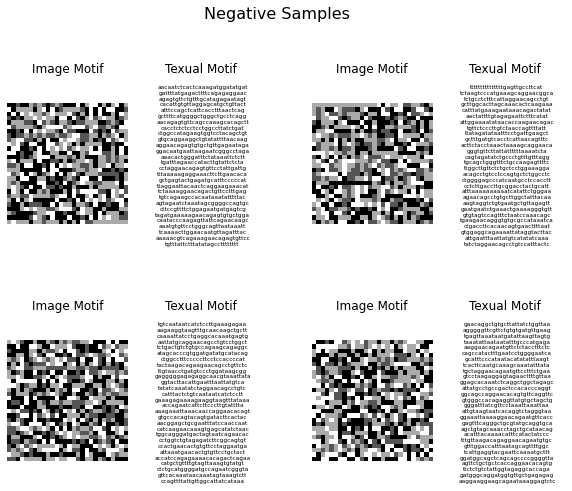

In [11]:
show_coupled(data=(neg_imgs, neg_chars),
             title='Negative Samples')